#Task 1: Acquire and pre-process the Web of Science Dataset

The dataset that will be used is the Web of Science dataset, found here: https://data.mendeley.com/datasets/9rw3vkcfy4/6.

In [ ]:
# throws an error if your Drive folder doesn't contain everything needed
from google.colab import drive
drive.mount('/content/drive/')

!ls "/content/drive/My Drive/Comp551/Assignment 4"


Mounted at /content/drive/
9rw3vkcfy4-6  a4.ipynb	COMP551_assignment4.pdf


In [ ]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # If using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
import pandas as pd
import numpy as np

base_path = "/content/drive/My Drive/Comp551/Assignment 4/9rw3vkcfy4-6/WebOfScience/WOS11967/"

# Load text and labels
with open(base_path + "X.txt", "r", encoding="utf-8") as f:
    abstracts = [line.strip() for line in f]

yl1 = np.loadtxt(base_path + "YL1.txt", dtype=int)
yl2 = np.loadtxt(base_path + "YL2.txt", dtype=int)

print("Num abstracts:", len(abstracts))
print("YL1 shape:", yl1.shape)
print("YL2 shape:", yl2.shape)


Num abstracts: 11967
YL1 shape: (11967,)
YL2 shape: (11967,)


In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z.,;:!?()\- ]', '', text) #only letters & punctuation
    return text.strip()

cleaned_abstracts = [clean_text(a) for a in abstracts]


For LSTM:

In [ ]:
!pip install gensim
import gensim
import gensim.downloader as api
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
tokens = [a.split() for a in cleaned_abstracts]

In [ ]:

def abstract_to_vec(tokens, model, vector_size=300):
    word_vectors = []
    for word in tokens:
        if word in model:
            word_vectors.append(model[word])
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

X_vectors = np.array([abstract_to_vec(t, model) for t in tokens])

print("X_vectors shape:", X_vectors.shape)


X_vectors shape: (11967, 300)


In [ ]:
assert len(X_vectors) == len(yl1) == len(yl2)
print("Vectors:", X_vectors.shape)
print("YL1:", yl1.shape)
print("YL2:", yl2.shape)

total = 0
missing = 0

for abstract in tokens:
    for word in abstract:
        total += 1
        if word not in model:
            missing += 1

print("Total words:", total)
print("Missing words:", missing)
print("ratio:", missing / total)



Vectors: (11967, 300)
YL1: (11967,)
YL2: (11967,)
Total words: 2334610
Missing words: 640638
ratio: 0.2744090019318002


27.4% word out-of-vocabulary. This is expected because the Web of Science dataset is full of specialized, technical words that don't often appear in news articles. Even so, we were able to find embeddings for more than 70% of words, which gave us a useful representation of the data.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, yl1_train, yl1_temp, yl2_train, yl2_temp = train_test_split(
    X_vectors, yl1, yl2, test_size=0.2, random_state=42, stratify=yl1
)

X_val, X_test, yl1_val, yl1_test, yl2_val, yl2_test = train_test_split(
    X_temp, yl1_temp, yl2_temp, test_size=0.5, random_state=42, stratify=yl1_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (9573, 300)
Val: (1197, 300)
Test: (1197, 300)


For BERT:

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.1 MB/s eta 0:00:00


Using Hugging Face which provides access to state-of-the-art pretrained models such as BERT, which are trained on large-scale corpora and are capable of capturing deep semantic and contextual representations of text.

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def bert_clean(text):
    text = text.strip()
    text = " ".join(text.split())
    return text

bert_texts = [bert_clean(t) for t in cleaned_abstracts]


In [ ]:
import torch

MAX_LEN = 256
encoded_inputs = tokenizer(
    bert_texts,
    padding=True,
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

labels_l1 = torch.tensor(yl1)
labels_l2 = torch.tensor(yl2)

In [ ]:
print("Input IDs shape:", encoded_inputs["input_ids"].shape)
print("Attention mask shape:", encoded_inputs["attention_mask"].shape)
print("Token Type IDs shape:", encoded_inputs["token_type_ids"].shape)

print("L1 labels shape:", labels_l1.shape)
print("L2 labels shape:", labels_l2.shape)

Input IDs shape: torch.Size([11967, 256])
Attention mask shape: torch.Size([11967, 256])
Token Type IDs shape: torch.Size([11967, 256])
L1 labels shape: torch.Size([11967])
L2 labels shape: torch.Size([11967])


In [ ]:
from torch.utils.data import Dataset

class WOSBERTDataset(Dataset):
    def __init__(self, encodings, labels_l1, labels_l2):
        self.encodings = encodings
        self.labels_l1 = labels_l1
        self.labels_l2 = labels_l2

    def __len__(self):
        return len(self.labels_l1)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels_l1"] = self.labels_l1[idx]
        item["labels_l2"] = self.labels_l2[idx]
        return item

dataset = WOSBERTDataset(encoded_inputs, labels_l1, labels_l2)

In [ ]:
sample = dataset[0]
print("Keys:", sample.keys())
print("Input IDs length:", len(sample["input_ids"]))
print("L1 label:", sample["labels_l1"])
print("L2 label:", sample["labels_l2"])

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels_l1', 'labels_l2'])
Input IDs length: 256
L1 label: tensor(2)
L2 label: tensor(2)


Max sequence length worked, input is padded/truncated correctly;

This abstract belongs to L1 class index 2, L2 class index 2.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

indices = np.arange(len(labels_l1))

#combined label just for splitting
combined_labels = labels_l1 * 1000 + labels_l2

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.1,
    random_state=42,
    stratify=combined_labels
)

train_idx, val_idx = train_test_split(
    train_idx,
    test_size=0.1,
    random_state=42,
    stratify=combined_labels[train_idx]
)

In [ ]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
from collections import Counter

train_l1 = [dataset[i]["labels_l1"].item() for i in train_idx]
val_l1 = [dataset[i]["labels_l1"].item() for i in val_idx]
test_l1 = [dataset[i]["labels_l1"].item() for i in test_idx]
train_l2 = [dataset[i]["labels_l2"].item() for i in train_idx]
val_l2 = [dataset[i]["labels_l2"].item() for i in val_idx]
test_l2 = [dataset[i]["labels_l2"].item() for i in test_idx]

#Task 2: Implement LSTM and BERT models



In [ ]:
# Single LSTM Unit (take x_t, h_t-1, c_t-1 and output h_t, c_t)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class LSTMUnitBase(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # Input gate weights
        self.W_xi = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hi = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))
        # Forget gate weights
        self.W_xf = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hf = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))
        # Candidate weights
        self.W_xg = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hg = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_g = nn.Parameter(torch.zeros(hidden_dim))
        # Output gate weights
        self.W_xo = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_ho = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

    def forward(self, x_t, h_prev, c_prev):
        # gates value
        # Choice of these activation function mentioned in report
        input_gate = torch.sigmoid(x_t @ self.W_xi + h_prev @ self.W_hi + self.b_i)
        forget_gate = torch.sigmoid(x_t @ self.W_xf + h_prev @ self.W_hf + self.b_f)
        candidate_gate = torch.tanh(x_t @ self.W_xg + h_prev @ self.W_hg + self.b_g)
        output_gate = torch.sigmoid(x_t @ self.W_xo + h_prev @ self.W_ho + self.b_o)
        # Update memory cell state
        c_t = forget_gate * c_prev + input_gate * candidate_gate
        # Update hidden state (output of this lstm unit)
        h_t = output_gate * torch.tanh(c_t)
        return h_t, c_t

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int,
                 lstm_unit_class=LSTMUnitBase,device: str | None = None):

        super().__init__()
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.lstm_cell = lstm_unit_class(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.to(self.device)

    def forward(self, X_batch: torch.Tensor) -> torch.Tensor:

        X_batch = X_batch.to(self.device)
        batch_size = X_batch.size(0)
        h_t = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        h_t, c_t = self.lstm_cell(X_batch, h_t, c_t)
        logits = self.fc(h_t)
        return logits

    def fit(self,X_train: np.ndarray,y_train: np.ndarray, X_val: np.ndarray | None = None,
            y_val: np.ndarray | None = None,num_epochs: int = 10,batch_size: int = 64,
            lr: float = 1e-3, verbose = False,weight_decay=0):

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        train_ds = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        if X_val is not None and y_val is not None:
            X_val_t = torch.tensor(X_val, dtype=torch.float32)
            y_val_t = torch.tensor(y_val, dtype=torch.long)
            val_ds = TensorDataset(X_val_t, y_val_t)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        else:
            val_loader = None

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay= weight_decay)

        # Training
        for epoch in range(1, num_epochs + 1):
            self.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # 1) Forward pass
                logits = self.forward(X_batch)
                loss = criterion(logits, y_batch)

                # 2) Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 3) Track stats
                running_loss += loss.item() * X_batch.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

            train_loss = running_loss / total
            train_acc = correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            # Validation
            if val_loader is not None:
                val_loss, val_acc = self.evaluate_loader(val_loader, criterion)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)
                if verbose:
                    print(f"Epoch {epoch}/{num_epochs} - "
                          f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
                          f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
            else:
                if verbose:
                    print(f"Epoch {epoch}/{num_epochs} - "
                          f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}")

    def predict(self, X: np.ndarray, batch_size: int = 64) -> np.ndarray:
        self.eval()
        X_t = torch.tensor(X, dtype=torch.float32)
        dataset = TensorDataset(X_t)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        all_preds = []
        with torch.no_grad():
            for (X_batch,) in loader:
                X_batch = X_batch.to(self.device)
                logits = self.forward(X_batch)
                preds = logits.argmax(dim=1)
                all_preds.append(preds.cpu().numpy())

        y_hat = np.concatenate(all_preds, axis=0)
        return y_hat

    @staticmethod
    def evaluate_acc(y_true, y_pred) -> float:
        y_true = np.asarray(y_true).reshape(-1)
        y_pred = np.asarray(y_pred).reshape(-1)
        assert y_true.shape == y_pred.shape
        return float((y_true == y_pred).mean())


    def evaluate_loader(self, loader, criterion):
        self.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                logits = self.forward(X_batch)
                loss = criterion(logits, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        return total_loss / total, correct / total

Define BERT classifier Model

In [ ]:
from transformers import get_linear_schedule_with_warmup, BertForSequenceClassification
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_labels_l1 = len(np.unique(labels_l1.numpy()))
print("YL1 number of classes =", num_labels_l1)

bert_l1 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels_l1
).to(device)

num_labels_l2 = len(np.unique(yl2))
print("YL2 number of classes =", num_labels_l2)

Using device: cuda
YL1 number of classes = 7


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


YL2 number of classes = 5


##Task 3: Run experiments

Hyperparameter Tuning for LSTM Modle (use YL1 to tune)

In [ ]:
# Tune hidden dimension
hidden_search = [64, 128, 256, 512, 1024]
hidden_results = {}

for h in hidden_search:
    set_seed(42)
    model = LSTMModel(input_dim=300, hidden_dim=h, num_classes=len(np.unique(yl1_train)))
    model.fit(
        X_train, yl1_train,
        X_val=X_val, y_val=yl1_val,
        num_epochs=8,
        batch_size=64,
        lr=0.001,
    )
    y_pred = model.predict(X_val)
    val_acc = LSTMModel.evaluate_acc(yl1_val, y_pred)
    hidden_results[h] = val_acc

print("\nHidden dim tuning results:")
for h, acc in hidden_results.items():
    print(f"hidden_dim={h} -> val_acc={acc:.4f}")

best_hidden = max(hidden_results, key=hidden_results.get)
print(f"\nBest hidden_dim: {best_hidden}")


Hidden dim tuning results:
hidden_dim=64 -> val_acc=0.7978
hidden_dim=128 -> val_acc=0.8020
hidden_dim=256 -> val_acc=0.7995
hidden_dim=512 -> val_acc=0.8204
hidden_dim=1024 -> val_acc=0.8145

Best hidden_dim: 512


In [ ]:
# Tune Learning Rate
lr_search = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
lr_results = {}

for lr in lr_search:
    set_seed(42)
    model = LSTMModel(input_dim=300, hidden_dim=512, num_classes=len(np.unique(yl1_train)))
    model.fit(
        X_train, yl1_train,
        X_val=X_val, y_val=yl1_val,
        num_epochs=8,
        batch_size=64,
        lr=lr,
    )
    y_pred = model.predict(X_val)
    val_acc = LSTMModel.evaluate_acc(yl1_val, y_pred)
    lr_results[lr] = val_acc

print("\nLearning Rate tuning results:")
for lr, acc in lr_results.items():
    print(f"lr={lr} -> val_acc={acc:.4f}")

best_lr = max(lr_results, key=lr_results.get)
print(f"\nBest lr: {best_lr}")


Learning Rate tuning results:
lr=0.01 -> val_acc=0.8187
lr=0.005 -> val_acc=0.8246
lr=0.001 -> val_acc=0.8204
lr=0.0005 -> val_acc=0.7995
lr=0.0001 -> val_acc=0.6901

Best lr: 0.005


In [ ]:
# Tune batch size
batch_search = [32, 64, 128, 512]
batch_results = {}

for bs in batch_search:
    set_seed(42)
    model = LSTMModel(input_dim=300, hidden_dim=512, num_classes=len(np.unique(yl1_train)))
    model.fit(
        X_train, yl1_train,
        X_val=X_val, y_val=yl1_val,
        num_epochs=8,
        batch_size=bs,
        lr=0.005,
    )
    y_pred = model.predict(X_val)
    val_acc = LSTMModel.evaluate_acc(yl1_val, y_pred)
    batch_results[bs] = val_acc

print("\nBatch size tuning results:")
for bs, acc in batch_results.items():
    print(f"batch_size={bs} -> val_acc={acc:.4f}")

best_batch = max(batch_results, key=batch_results.get)
print(f"\nBest batch size: {best_batch}")


Batch size tuning results:
batch_size=32 -> val_acc=0.8145
batch_size=64 -> val_acc=0.8246
batch_size=128 -> val_acc=0.8212
batch_size=512 -> val_acc=0.8129

Best batch size: 64


In [ ]:
# Tune l2
l2_search = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]
l2_results = {}

for l2 in l2_search:
    set_seed(42)
    model = LSTMModel(input_dim=300, hidden_dim=512, num_classes=len(np.unique(yl1_train)))
    model.fit(
        X_train, yl1_train,
        X_val=X_val, y_val=yl1_val,
        num_epochs=8,
        batch_size=64,
        lr=0.005,
        weight_decay=l2
    )
    y_pred = model.predict(X_val)
    val_acc = LSTMModel.evaluate_acc(yl1_val, y_pred)
    l2_results[l2] = val_acc

print("\nL2 tuning results:")
for l2, acc in l2_results.items():
    print(f"l2={l2} -> val_acc={acc:.4f}")

best_l2 = max(l2_results, key=l2_results.get)
print(f"\nBest l2: {best_l2}")


L2 tuning results:
l2=1e-06 -> val_acc=0.8221
l2=5e-06 -> val_acc=0.8170
l2=1e-05 -> val_acc=0.8145
l2=5e-05 -> val_acc=0.8028
l2=0.0001 -> val_acc=0.7995

Best l2: 1e-06


Train LSTM on YL1 and YL2

In [ ]:
# Graphing helper
import matplotlib.pyplot as plt

def plot_training_curves(model, title="Training Curve"):
    epochs = range(1, len(model.train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=16, fontweight='bold')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, model.train_losses, label="Train Loss", marker="o")
    if hasattr(model, "val_losses") and len(model.val_losses) > 0:
        plt.plot(epochs, model.val_losses, label="Val Loss", marker="o")
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, model.train_accuracies, label="Train Acc", marker="o")
    if hasattr(model, "val_accuracies") and len(model.val_accuracies) > 0:
        plt.plot(epochs, model.val_accuracies, label="Val Acc", marker="o")
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
# Train Baseline LSTM on YL1
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl1_train))
lstm_unit_class = LSTMUnitBase
model_base1 = LSTMModel(input_dim, hidden_dim, num_classes, lstm_unit_class)
model_base1.fit(X_train, yl1_train, X_val=X_val, y_val=yl1_val, num_epochs=25, batch_size=64, lr=0.005)
y_test_pred = model_base1.predict(X_test)
test_acc_base1 = LSTMModel.evaluate_acc(yl1_test, y_test_pred)
print("Test accuracy Baseline LSTM on YL1:", test_acc_base1)

Test accuracy Baseline LSTM on YL1: 0.8395989974937343


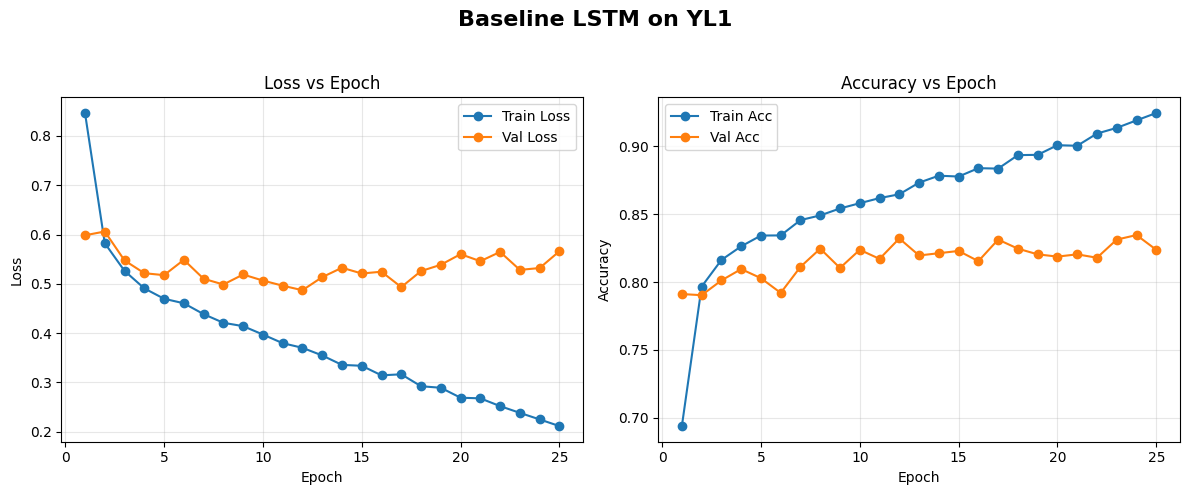

In [ ]:
plot_training_curves(model_base1, title="Baseline LSTM on YL1")

In [ ]:
# Train Baseline LSTM on YL2
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl2_train))
lstm_unit_class = LSTMUnitBase
model_base2 = LSTMModel(input_dim, hidden_dim, num_classes,lstm_unit_class)
model_base2.fit(X_train, yl2_train, X_val=X_val, y_val=yl2_val, num_epochs=25, batch_size=64, lr=0.005)
y_test_pred = model_base2.predict(X_test)
test_acc_base2 = LSTMModel.evaluate_acc(yl2_test, y_test_pred)
print("Test accuracy Baseline LSTM on YL2:", test_acc_base2)

Test accuracy Baseline LSTM on YL2: 0.7017543859649122


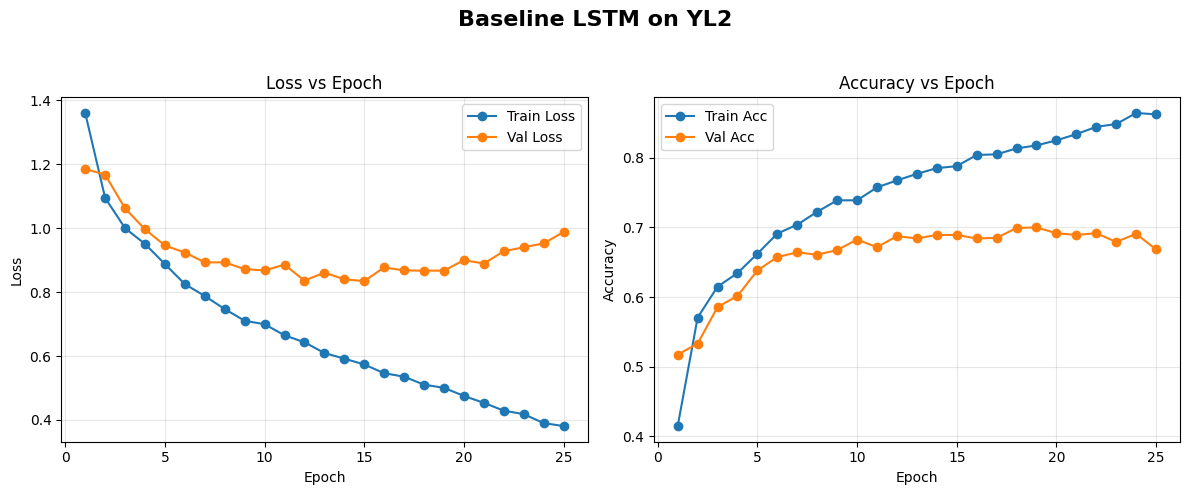

In [ ]:
plot_training_curves(model_base2, title="Baseline LSTM on YL2")

In [ ]:
# LSTM with Relu activation function for Candidate gate instead of tanh
class LSTMUnitRelu(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # Input gate weights
        self.W_xi = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hi = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))
        # Forget gate weights
        self.W_xf = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hf = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))
        # Candidate weights
        self.W_xg = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hg = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_g = nn.Parameter(torch.zeros(hidden_dim))
        # Output gate weights
        self.W_xo = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_ho = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

    def forward(self, x_t, h_prev, c_prev):
        # gates value
        input_gate = torch.sigmoid(x_t @ self.W_xi + h_prev @ self.W_hi + self.b_i)
        forget_gate = torch.sigmoid(x_t @ self.W_xf + h_prev @ self.W_hf + self.b_f)
        candidate_gate = torch.relu(x_t @ self.W_xg + h_prev @ self.W_hg + self.b_g) # use relu
        output_gate = torch.sigmoid(x_t @ self.W_xo + h_prev @ self.W_ho + self.b_o)
        # Update memory cell state
        c_t = forget_gate * c_prev + input_gate * candidate_gate
        # Update hidden state (output of this lstm unit)
        h_t = output_gate * torch.tanh(c_t)
        return h_t, c_t

In [ ]:
# Train LSTM With Relu Candidate Gate on YL1
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl1_train))
lstm_unit_class = LSTMUnitRelu
model_relu1 = LSTMModel(input_dim, hidden_dim, num_classes, lstm_unit_class)
model_relu1.fit(X_train, yl1_train, X_val=X_val, y_val=yl1_val, num_epochs=25, batch_size=64, lr=0.005)
y_test_pred = model_relu1.predict(X_test)
test_acc_relu1 = LSTMModel.evaluate_acc(yl1_test, y_test_pred)
print("Test accuracy LSTM Relu Candidate Gate on YL1:", test_acc_relu1)

Test accuracy LSTM Relu Candidate Gate on YL1: 0.8329156223893066


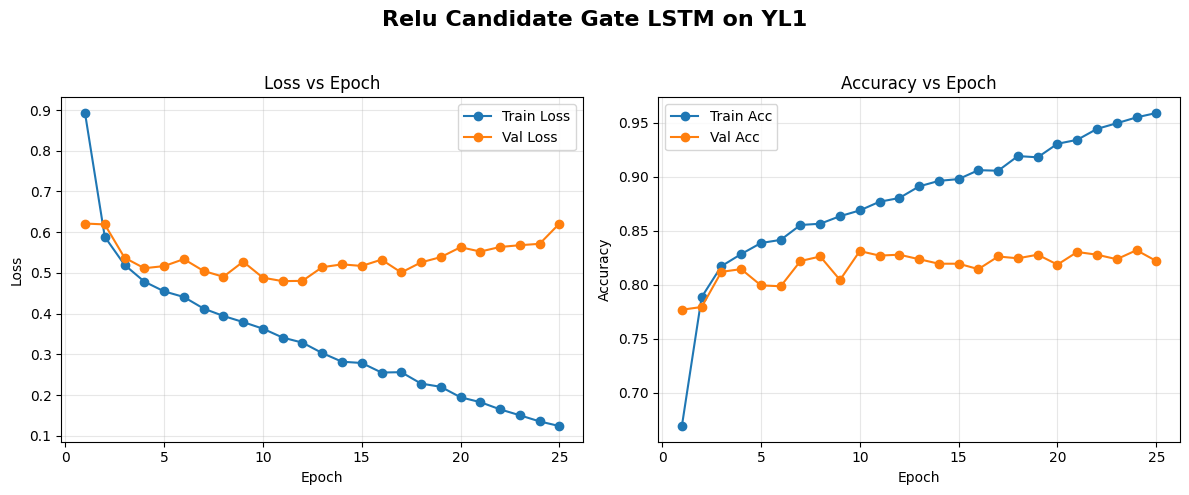

In [ ]:
plot_training_curves(model_relu1, title="Relu Candidate Gate LSTM on YL1")

In [ ]:
# Train LSTM With Relu Candidate Gate on YL2
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl2_train))
lstm_unit_class = LSTMUnitRelu
model_relu2 = LSTMModel(input_dim, hidden_dim, num_classes,lstm_unit_class)
model_relu2.fit(X_train, yl2_train, X_val=X_val, y_val=yl2_val, num_epochs=25, batch_size=64, lr=0.005)
y_test_pred = model_relu2.predict(X_test)
test_acc_relu2 = LSTMModel.evaluate_acc(yl2_test, y_test_pred)
print("Test accuracy LSTM Relu Candidate Gate on YL2:", test_acc_relu2)

Test accuracy LSTM Relu Candidate Gate on YL2: 0.7251461988304093


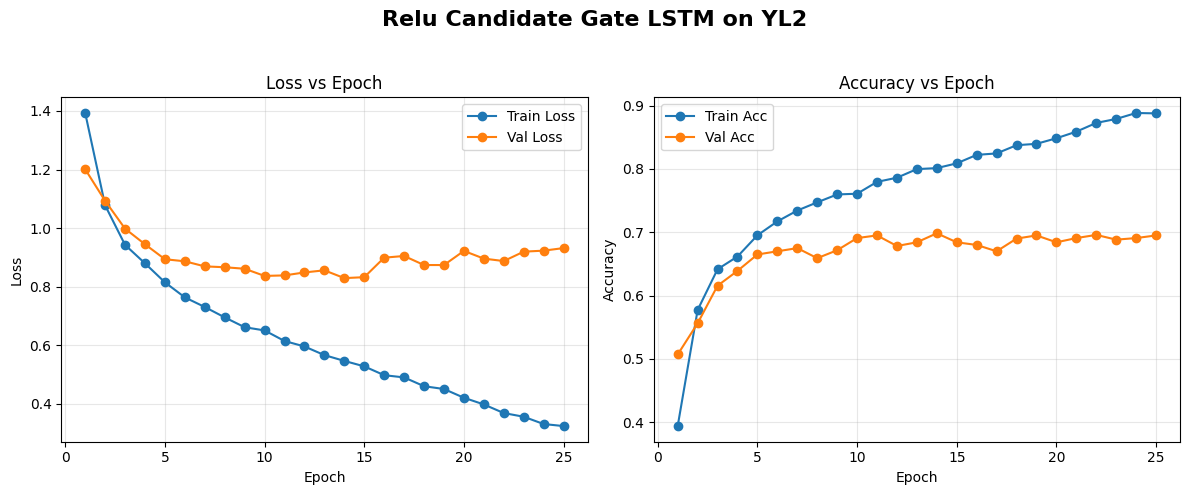

In [ ]:
plot_training_curves(model_relu2, title="Relu Candidate Gate LSTM on YL2")

In [ ]:
# LSTM with Xavier Initialization
class LSTMUnitInit(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # Input gate weights
        self.W_xi = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hi = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))
        # Forget gate weights
        self.W_xf = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hf = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))
        # Candidate weights
        self.W_xg = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_hg = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_g = nn.Parameter(torch.zeros(hidden_dim))
        # Output gate weights
        self.W_xo = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.W_ho = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.1)
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

        for param in [self.W_xi, self.W_hi, self.W_xf, self.W_hf, self.W_xg, self.W_hg, self.W_xo, self.W_ho]:
            nn.init.xavier_uniform_(param)
        nn.init.zeros_(self.b_i)
        nn.init.ones_(self.b_f)
        nn.init.zeros_(self.b_g)
        nn.init.zeros_(self.b_o)

    def forward(self, x_t, h_prev, c_prev):
        # gates value
        input_gate = torch.sigmoid(x_t @ self.W_xi + h_prev @ self.W_hi + self.b_i)
        forget_gate = torch.sigmoid(x_t @ self.W_xf + h_prev @ self.W_hf + self.b_f)
        candidate_gate = torch.tanh(x_t @ self.W_xg + h_prev @ self.W_hg + self.b_g)
        output_gate = torch.sigmoid(x_t @ self.W_xo + h_prev @ self.W_ho + self.b_o)
        # Update memory cell state
        c_t = forget_gate * c_prev + input_gate * candidate_gate
        # Update hidden state (output of this lstm unit)
        h_t = output_gate * torch.tanh(c_t)
        return h_t, c_t

In [ ]:
# Train LSTM With Better Initialization on YL1
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl1_train))
lstm_unit_class = LSTMUnitInit
model_init1 = LSTMModel(input_dim, hidden_dim, num_classes, lstm_unit_class)
model_init1.fit(X_train, yl1_train, X_val=X_val, y_val=yl1_val, num_epochs=25, batch_size=64, lr=0.005)
y_test_pred = model_init1.predict(X_test)
test_acc_init1 = LSTMModel.evaluate_acc(yl1_test, y_test_pred)
print("Test accuracy LSTM Better Initialization on YL1:", test_acc_init1)

Test accuracy LSTM Better Initialization on YL1: 0.8421052631578947


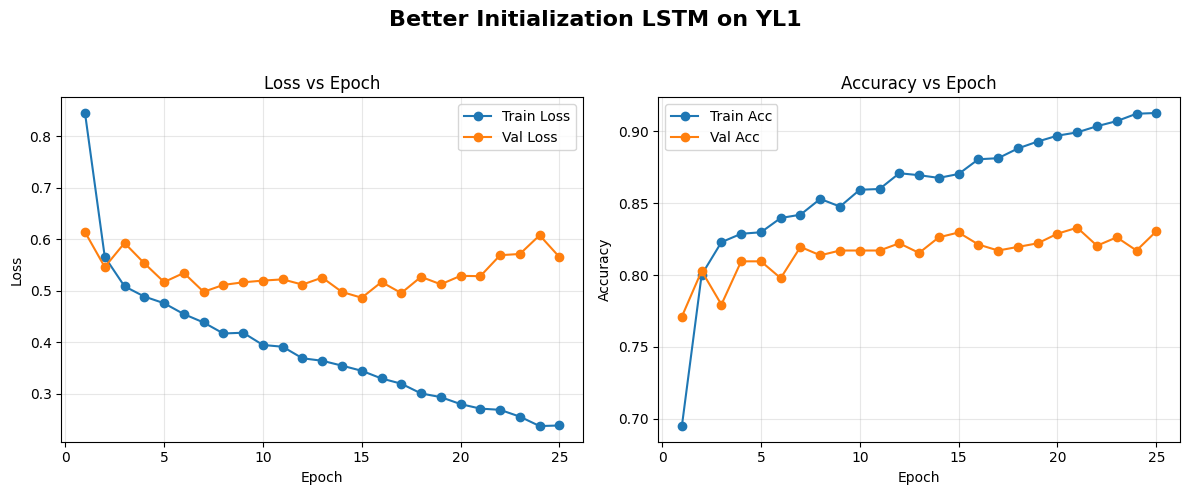

In [ ]:
plot_training_curves(model_init1, title="Better Initialization LSTM on YL1")

In [ ]:
# Train LSTM With Better Initialization on YL2
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl2_train))
lstm_unit_class = LSTMUnitInit
model_init2 = LSTMModel(input_dim, hidden_dim, num_classes,lstm_unit_class)
model_init2.fit(X_train, yl2_train, X_val=X_val, y_val=yl2_val, num_epochs=25, batch_size=64, lr=0.005)
y_test_pred = model_init2.predict(X_test)
test_acc_init2 = LSTMModel.evaluate_acc(yl2_test, y_test_pred)
print("Test accuracy LSTM Better Initialization on YL2:", test_acc_init2)

Test accuracy LSTM Better Initialization on YL2: 0.7176274018379282


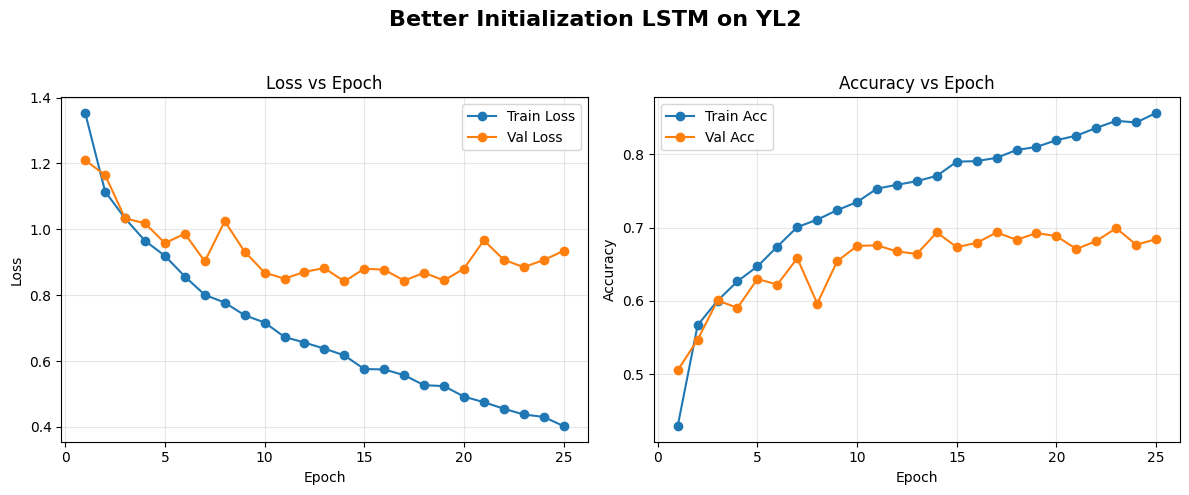

In [ ]:
plot_training_curves(model_init2, title="Better Initialization LSTM on YL2")

In [ ]:
# Train LSTM With Weight Decay Regularization on YL1
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl1_train))
lstm_unit_class = LSTMUnitBase
model_reg1 = LSTMModel(input_dim, hidden_dim, num_classes, lstm_unit_class)
model_reg1.fit(X_train, yl1_train, X_val=X_val, y_val=yl1_val, num_epochs=25, batch_size=64, lr=0.005, weight_decay= 1e-6)
y_test_pred = model_reg1.predict(X_test)
test_acc_reg1 = LSTMModel.evaluate_acc(yl1_test, y_test_pred)
print("Test accuracy LSTM Weight Decay Regularized on YL1:", test_acc_reg1)

Test accuracy LSTM Weight Decay Regularized on YL1: 0.8462823725981621


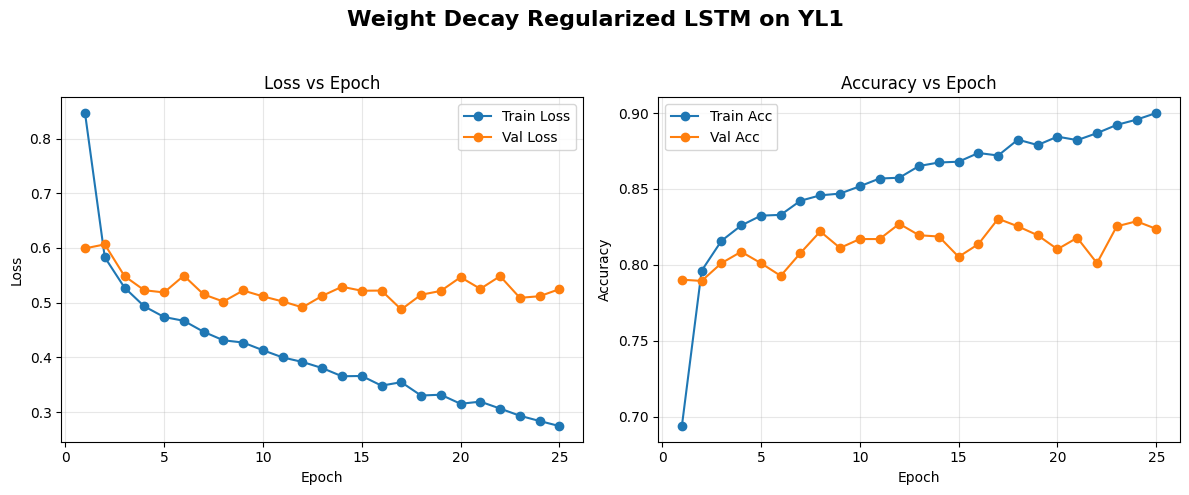

In [ ]:
plot_training_curves(model_reg1, title="Weight Decay Regularized LSTM on YL1")

In [ ]:
# Train LSTM With Weight Decay Regularization on YL2
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl2_train))
lstm_unit_class = LSTMUnitBase
model_reg2 = LSTMModel(input_dim, hidden_dim, num_classes,lstm_unit_class)
model_reg2.fit(X_train, yl2_train, X_val=X_val, y_val=yl2_val, num_epochs=25, batch_size=64, lr=0.005, weight_decay= 1e-6)
y_test_pred = model_reg2.predict(X_test)
test_acc_reg2 = LSTMModel.evaluate_acc(yl2_test, y_test_pred)
print("Test accuracy LSTM Weight Decay Regularized on YL2:", test_acc_reg2)

Test accuracy LSTM Weight Decay Regularized on YL2: 0.7151211361737677


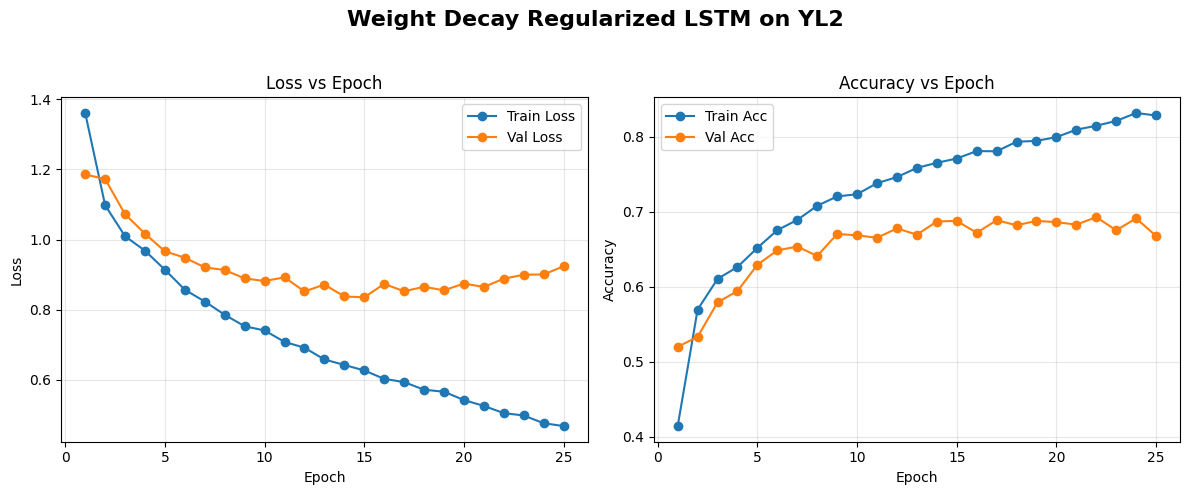

In [ ]:
plot_training_curves(model_reg2, title="Weight Decay Regularized LSTM on YL2")

In [ ]:
# LSTM with Normalization
class LSTMModelNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes,
                 lstm_unit_class=LSTMUnitBase, device=None):
        super().__init__()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.lstm_cell = lstm_unit_class(input_dim, hidden_dim)
        self.layernorm_h = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.to(self.device)

    def forward(self, X_batch: torch.Tensor) -> torch.Tensor:

        X_batch = X_batch.to(self.device)
        batch_size = X_batch.size(0)
        h_t = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        c_t = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        h_t, c_t = self.lstm_cell(X_batch, h_t, c_t)
        h_t = self.layernorm_h(h_t)
        logits = self.fc(h_t)
        return logits

    def fit(self,X_train: np.ndarray,y_train: np.ndarray, X_val: np.ndarray | None = None,
            y_val: np.ndarray | None = None,num_epochs: int = 10,batch_size: int = 64,
            lr: float = 1e-3, verbose = False,weight_decay=0):

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        train_ds = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        if X_val is not None and y_val is not None:
            X_val_t = torch.tensor(X_val, dtype=torch.float32)
            y_val_t = torch.tensor(y_val, dtype=torch.long)
            val_ds = TensorDataset(X_val_t, y_val_t)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        else:
            val_loader = None

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay= weight_decay)

        # Training
        for epoch in range(1, num_epochs + 1):
            self.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                # 1) Forward pass
                logits = self.forward(X_batch)
                loss = criterion(logits, y_batch)

                # 2) Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 3) Track stats
                running_loss += loss.item() * X_batch.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

            train_loss = running_loss / total
            train_acc = correct / total
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            # Validation
            if val_loader is not None:
                val_loss, val_acc = self.evaluate_loader(val_loader, criterion)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)
                if verbose:
                    print(f"Epoch {epoch}/{num_epochs} - "
                          f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
                          f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
            else:
                if verbose:
                    print(f"Epoch {epoch}/{num_epochs} - "
                          f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}")

    def predict(self, X: np.ndarray, batch_size: int = 64) -> np.ndarray:
        self.eval()
        X_t = torch.tensor(X, dtype=torch.float32)
        dataset = TensorDataset(X_t)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        all_preds = []
        with torch.no_grad():
            for (X_batch,) in loader:
                X_batch = X_batch.to(self.device)
                logits = self.forward(X_batch)
                preds = logits.argmax(dim=1)
                all_preds.append(preds.cpu().numpy())

        y_hat = np.concatenate(all_preds, axis=0)
        return y_hat

    @staticmethod
    def evaluate_acc(y_true, y_pred) -> float:
        y_true = np.asarray(y_true).reshape(-1)
        y_pred = np.asarray(y_pred).reshape(-1)
        assert y_true.shape == y_pred.shape
        return float((y_true == y_pred).mean())


    def evaluate_loader(self, loader, criterion):
        self.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                logits = self.forward(X_batch)
                loss = criterion(logits, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        return total_loss / total, correct / total

In [ ]:
# Train LSTM With Normalization on YL1
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl1_train))
lstm_unit_class = LSTMUnitBase
model_norm1 = LSTMModelNorm(input_dim, hidden_dim, num_classes, lstm_unit_class)
model_norm1.fit(X_train, yl1_train, X_val=X_val, y_val=yl1_val, num_epochs=25, batch_size=64, lr=0.005)
y_test_pred = model_norm1.predict(X_test)
test_acc_norm1 = LSTMModel.evaluate_acc(yl1_test, y_test_pred)
print("Test accuracy LSTM Normalization on YL1:", test_acc_norm1)

Test accuracy LSTM Normalization on YL1: 0.8362573099415205


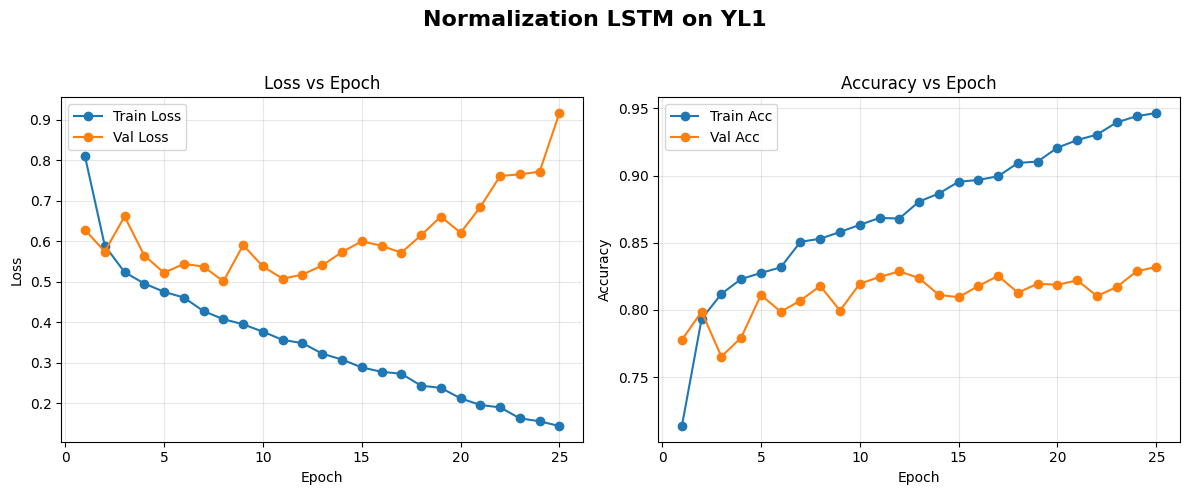

In [ ]:
plot_training_curves(model_norm1, title="Normalization LSTM on YL1")

In [ ]:
# Train LSTM With Normalization on YL2
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl2_train))
lstm_unit_class = LSTMUnitBase
model_norm2 = LSTMModelNorm(input_dim, hidden_dim, num_classes,lstm_unit_class)
model_norm2.fit(X_train, yl2_train, X_val=X_val, y_val=yl2_val, num_epochs=25, batch_size=64, lr=0.005)
y_test_pred = model_norm2.predict(X_test)
test_acc_norm2 = LSTMModel.evaluate_acc(yl2_test, y_test_pred)
print("Test accuracy LSTM Normalization on YL2:", test_acc_norm2)

Test accuracy LSTM Normalization on YL2: 0.7000835421888053


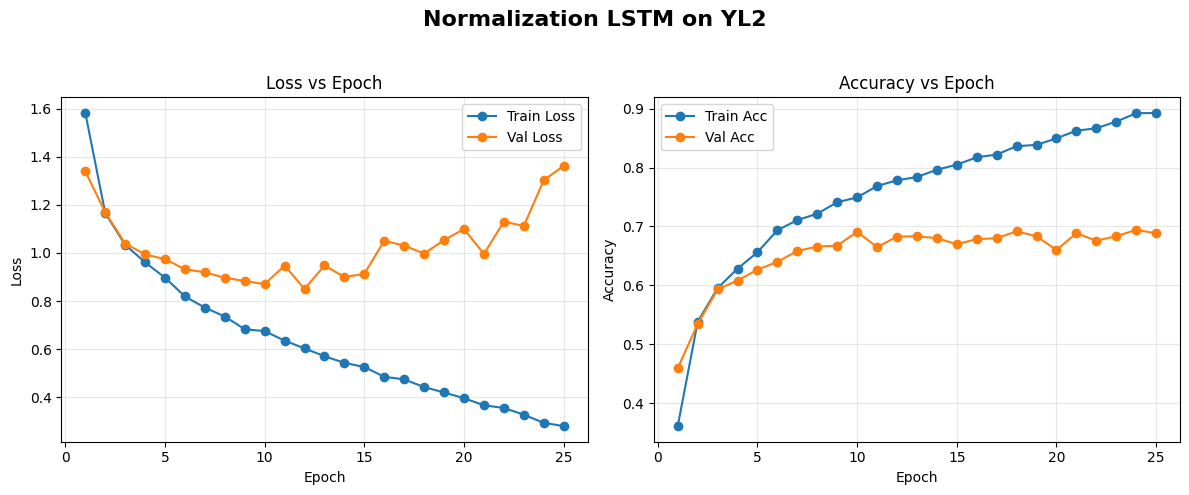

In [ ]:
plot_training_curves(model_norm2, title="Normalization LSTM on YL2")

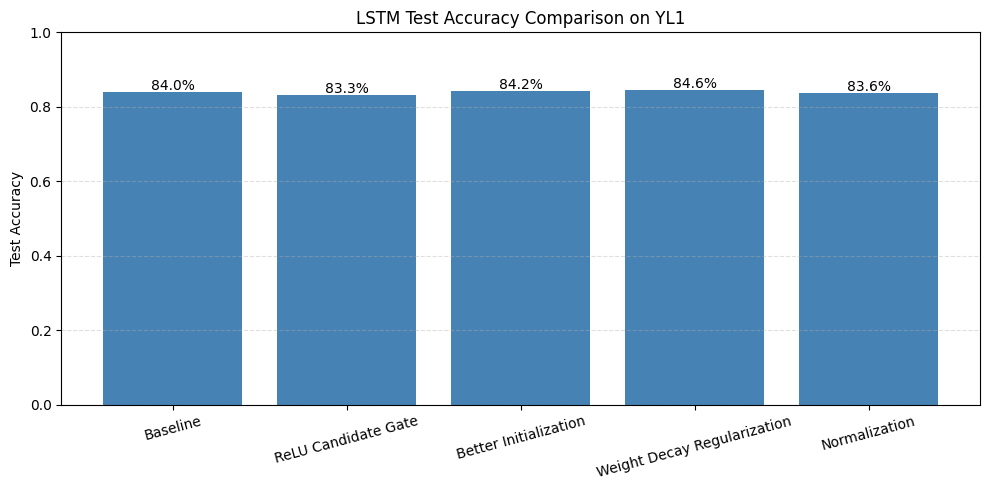

In [ ]:
# All Model for YL1 Compared
accuracies = [test_acc_base1, test_acc_relu1, test_acc_init1, test_acc_reg1, test_acc_norm1]
model_names = ["Baseline","ReLU Candidate Gate", "Better Initialization", "Weight Decay Regularization", "Normalization"]
accuracies = np.array(accuracies)
plt.figure(figsize=(10, 5))
x_positions = np.arange(len(model_names))
plt.bar(x_positions, accuracies, color="steelblue")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc*100:.1f}%",
             ha="center", fontsize=10)
plt.xticks(x_positions, model_names, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Test Accuracy")
plt.title("LSTM Test Accuracy Comparison on YL1")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

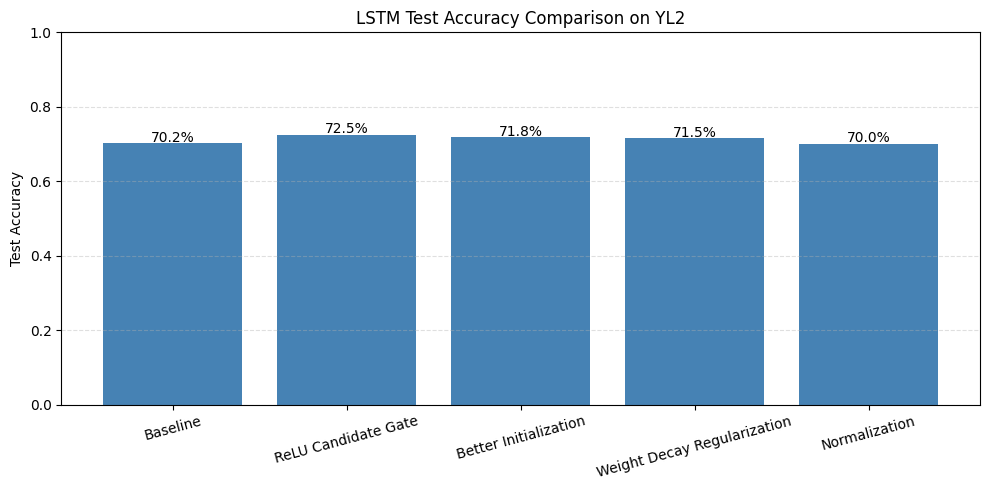

In [ ]:
# All Model for YL2 Compared
accuracies = [test_acc_base2, test_acc_relu2, test_acc_init2, test_acc_reg2, test_acc_norm2]
model_names = ["Baseline","ReLU Candidate Gate", "Better Initialization", "Weight Decay Regularization", "Normalization"]
accuracies = np.array(accuracies)
plt.figure(figsize=(10, 5))
x_positions = np.arange(len(model_names))
plt.bar(x_positions, accuracies, color="steelblue")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc*100:.1f}%",
             ha="center", fontsize=10)
plt.xticks(x_positions, model_names, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Test Accuracy")
plt.title("LSTM Test Accuracy Comparison on YL2")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Evaluate BERT on YL1 and YL2

In [ ]:
def train_one_epoch_bert(model, dataloader, optimizer, scheduler, device, label_key="labels_l1"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch[label_key].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        batch_size = input_ids.size(0)
        running_loss += loss.item() * batch_size
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += batch_size

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def eval_bert(model, dataloader, device, label_key="labels_l1"):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            labels = batch[label_key].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            batch_size = input_ids.size(0)
            total_loss += loss.item() * batch_size
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += batch_size

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
#BERT on YL1
num_labels_l1 = len(np.unique(yl1))
bert_l1 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels_l1
).to(device)

lr = 2e-5
num_epochs_l1 = 3
optimizer_l1 = AdamW(bert_l1.parameters(), lr=lr)

total_steps_l1 = len(train_loader) * num_epochs_l1
scheduler_l1 = get_linear_schedule_with_warmup(
    optimizer_l1,
    num_warmup_steps=int(0.1 * total_steps_l1),
    num_training_steps=total_steps_l1
)

bert_l1_train_losses = []
bert_l1_train_accuracies = []
bert_l1_val_losses = []
bert_l1_val_accuracies = []

best_val_acc_l1 = 0.0
best_model_path_l1 = "/content/bert_l1_best.pt"

for epoch in range(1, num_epochs_l1 + 1):
    print(f"\nYL1 Epoch {epoch}/{num_epochs_l1}")
    train_loss, train_acc = train_one_epoch_bert(
        bert_l1, train_loader, optimizer_l1, scheduler_l1, device, label_key="labels_l1"
    )
    bert_l1_train_losses.append(train_loss)
    bert_l1_train_accuracies.append(train_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")

    val_loss, val_acc = eval_bert(
        bert_l1, val_loader, device, label_key="labels_l1"
    )
    bert_l1_val_losses.append(val_loss)
    bert_l1_val_accuracies.append(val_acc)
    print(f"Val   loss: {val_loss:.4f}, Val   acc: {val_acc:.4f}")

    if val_acc > best_val_acc_l1: #save new best YL1 model
        best_val_acc_l1 = val_acc
        torch.save(bert_l1.state_dict(), best_model_path_l1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



YL1 Epoch 1/3
Train loss: 0.7777, Train acc: 0.7352
Val   loss: 0.2986, Val   acc: 0.9174

YL1 Epoch 2/3
Train loss: 0.2060, Train acc: 0.9414
Val   loss: 0.2441, Val   acc: 0.9229

YL1 Epoch 3/3
Train loss: 0.1203, Train acc: 0.9675
Val   loss: 0.2663, Val   acc: 0.9201


In [ ]:
# BERT YL1 test accuraccy
bert_l1.load_state_dict(torch.load(best_model_path_l1, map_location=device))
test_loss_l1, test_acc_l1 = eval_bert(
    bert_l1, test_loader, device, label_key="labels_l1"
)
print(f"\n[YL1] BERT Test loss: {test_loss_l1:.4f}, Test acc: {test_acc_l1:.4f}")


[YL1] BERT Test loss: 0.2153, Test acc: 0.9424


In [ ]:
# BERT on YL2
num_labels_l2 = len(np.unique(yl2))
bert_l2 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels_l2
).to(device)

lr = 2e-5
num_epochs_l2 = 3
optimizer_l2 = AdamW(bert_l2.parameters(), lr=lr)

total_steps_l2 = len(train_loader) * num_epochs_l2
scheduler_l2 = get_linear_schedule_with_warmup(
    optimizer_l2,
    num_warmup_steps=int(0.1 * total_steps_l2),
    num_training_steps=total_steps_l2
)

bert_l2_train_losses = []
bert_l2_train_accuracies = []
bert_l2_val_losses = []
bert_l2_val_accuracies = []

best_val_acc_l2 = 0.0
best_model_path_l2 = "/content/bert_l2_best.pt"

for epoch in range(1, num_epochs_l2 + 1):
    print(f"\nYL2 Epoch {epoch}/{num_epochs_l2}")
    train_loss, train_acc = train_one_epoch_bert(
        bert_l2, train_loader, optimizer_l2, scheduler_l2, device, label_key="labels_l2"
    )
    bert_l2_train_losses.append(train_loss)
    bert_l2_train_accuracies.append(train_acc)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")

    val_loss, val_acc = eval_bert(
        bert_l2, val_loader, device, label_key="labels_l2"
    )
    bert_l2_val_losses.append(val_loss)
    bert_l2_val_accuracies.append(val_acc)
    print(f"Val   loss: {val_loss:.4f}, Val   acc: {val_acc:.4f}")

    if val_acc > best_val_acc_l2: # save new best YL2 BERT model
        best_val_acc_l2 = val_acc
        torch.save(bert_l2.state_dict(), best_model_path_l2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



YL2 Epoch 1/3
Train loss: 1.0684, Train acc: 0.5599
Val   loss: 0.4804, Val   acc: 0.8375

YL2 Epoch 2/3
Train loss: 0.3509, Train acc: 0.8855
Val   loss: 0.4031, Val   acc: 0.8561

YL2 Epoch 3/3
Train loss: 0.2091, Train acc: 0.9373
Val   loss: 0.3965, Val   acc: 0.8672


In [ ]:
# BERT YL2 test accuracy
bert_l2.load_state_dict(torch.load(best_model_path_l2, map_location=device))
test_loss_l2, test_acc_l2 = eval_bert(
    bert_l2, test_loader, device, label_key="labels_l2"
)
print(f"\n[YL2] BERT Test loss: {test_loss_l2:.4f}, Test acc: {test_acc_l2:.4f}")


[YL2] BERT Test loss: 0.3725, Test acc: 0.8872


                   Model  YL1 Accuracy (7 classes)  YL2 Accuracy (34 classes)
0  LSTM (L2 Regularized)                  0.846282                   0.715121
1      BERT (Fine-tuned)                  0.942356                   0.887218


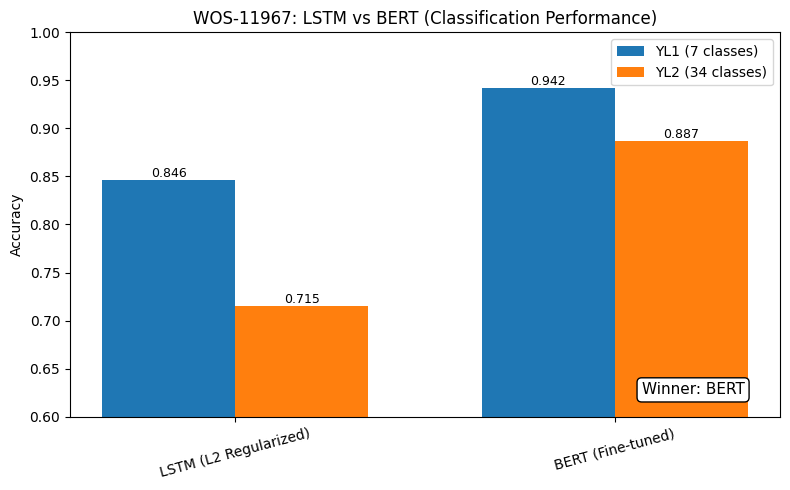

In [ ]:
import pandas as pd

# Accuracies
acc_lstm_yl1 = float(test_acc_reg1)
acc_lstm_yl2 = float(test_acc_reg2)
acc_bert_yl1 = float(test_acc_l1)
acc_bert_yl2 = float(test_acc_l2)
data = {
    "Model": ["LSTM (L2 Regularized)", "BERT (Fine-tuned)"],
    "YL1 Accuracy (7 classes)": [acc_lstm_yl1, acc_bert_yl1],
    "YL2 Accuracy (34 classes)": [acc_lstm_yl2, acc_bert_yl2],
}

df_results = pd.DataFrame(data)
print(df_results)

models = df_results["Model"].values
yl1_acc = df_results["YL1 Accuracy (7 classes)"].values
yl2_acc = df_results["YL2 Accuracy (34 classes)"].values

x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))

bars_yl1 = ax.bar(x-width/2, yl1_acc, width, label="YL1 (7 classes)")
bars_yl2 = ax.bar(x+width/2, yl2_acc, width, label="YL2 (34 classes)")

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.3f}",
                 ha="center", va="bottom", fontsize=9)

autolabel(bars_yl1)
autolabel(bars_yl2)
plt.ylabel("Accuracy")
plt.title("WOS-11967: LSTM vs BERT (Classification Performance)")
plt.xticks(x, models, rotation=15)
plt.ylim(0.6, 1.0)
plt.legend()
plt.text(0.95, 0.05, "Winner: BERT",
    transform=plt.gca().transAxes, fontsize=11,
    ha="right", va="bottom",
    bbox=dict(boxstyle="round,pad=0.3",
              edgecolor="black",
              facecolor="white"))
plt.tight_layout()
plt.show()

In [ ]:
def collect_examples(model, dataloader, tokenizer, device,
                     label_key="labels_l2",
                     num_correct=2, num_incorrect=2):
    model.eval()
    correct_examples = []
    incorrect_examples = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch[label_key].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=-1)

            for i in range(len(labels)):
                text_ids = input_ids[i]
                text = tokenizer.decode(text_ids, skip_special_tokens=True)
                true_label = labels[i].item()
                pred_label = preds[i].item()

                if true_label == pred_label and len(correct_examples) < num_correct:
                    correct_examples.append((text, true_label, pred_label))
                elif true_label != pred_label and len(incorrect_examples) < num_incorrect:
                    incorrect_examples.append((text, true_label, pred_label))

                if (len(correct_examples) >= num_correct and
                    len(incorrect_examples) >= num_incorrect):
                    return correct_examples, incorrect_examples

    return correct_examples, incorrect_examples

In [ ]:
# get attention matrix for one example
def get_attention_for_text(model, tokenizer, text, device,
                           layer_idx=-1, head_idx=0, max_len=256):
    model.eval()
    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_len
    )
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True
        )

    logits = outputs.logits
    prediction = logits.argmax(dim=-1).item()
    attentions = outputs.attentions
    attn_layer = attentions[layer_idx][0, head_idx]  # (seq_len, seq_len)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return tokens, attn_layer.cpu().numpy(), prediction


In [ ]:
# plot attention from cls to tokens
import seaborn as sns

def plot_cls_attention(tokens, attn_matrix, title=""):
    cls_to_tokens = attn_matrix[0]

    plt.figure(figsize=(max(8, len(tokens)*0.4), 3))
    sns.heatmap(cls_to_tokens[np.newaxis, :],
                xticklabels=tokens,
                yticklabels=["[CLS] → tokens"],
                cmap="viridis")
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
# Collect predictions and store examples for YL2
correct_examples = []
incorrect_examples = []

bert_l2.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels_l2"].to(device)

        outputs = bert_l2(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        for i in range(len(preds)):
            text = tokenizer.decode(
                input_ids[i],
                skip_special_tokens=True
            )
            y_true = labels[i].item()
            y_pred = preds[i].item()

            if y_true == y_pred:
                if len(correct_examples) < 5:   # store first 5 correct
                    correct_examples.append((text, y_true, y_pred))
            else:
                if len(incorrect_examples) < 5: # store first 5 incorrect
                    incorrect_examples.append((text, y_true, y_pred))
        if len(correct_examples) >= 5 and len(incorrect_examples) >= 5:
            break


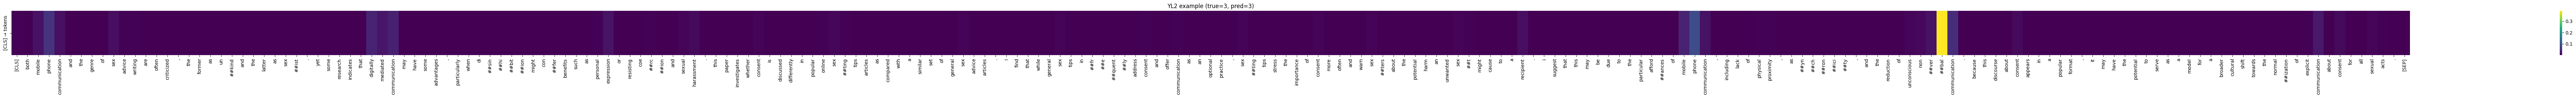

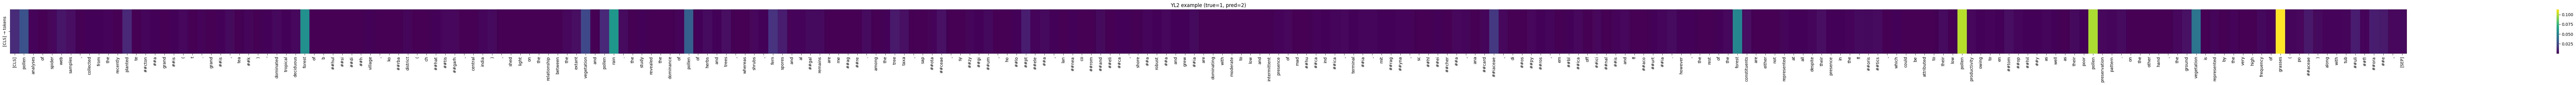

In [ ]:
# first correct and first incorrect from YL2
example_correct = correct_examples[0]
example_incorrect = incorrect_examples[0]

for text, y_true, y_pred in [example_correct, example_incorrect]:
    tokens, attn, pred = get_attention_for_text(
        bert_l2, tokenizer, text, device,
        layer_idx=-1, head_idx=0, max_len=MAX_LEN
    )
    title = f"YL2 example (true={y_true}, pred={pred})"
    plot_cls_attention(tokens, attn, title=title)

Correct example: [CLS] token focuses on a small set of domain-specific content words (e.g., technical keywords, method names, or application domains)

Incorrect example: attention is more spread out

Explored another pre-trained model for preparing data for LSTM.

In [ ]:
!pip install gensim
import gensim
import gensim.downloader as api
model2 = api.load("fasttext-wiki-news-subwords-300")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 38.0 MB/s eta 0:00:00
[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
import numpy as np

tokens = [a.split() for a in cleaned_abstracts]

def abstract_to_vec2(tokens, model2, vector_size=300):
    word_vectors = []

    for word in tokens:
        if word in model2:
            word_vectors.append(model2[word])
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

X_vectors2 = np.array([abstract_to_vec2(t, model2) for t in tokens])

print("X_vectors2 shape:", X_vectors2.shape)

assert len(X_vectors2) == len(yl1) == len(yl2)
print("Vectors:", X_vectors2.shape)
print("YL1:", yl1.shape)
print("YL2:", yl2.shape)


X_vectors2 shape: (11967, 300)
Vectors: (11967, 300)
YL1: (11967,)
YL2: (11967,)


In [ ]:
total = 0
missing = 0

for abstract in tokens:
    for word in abstract:
        total += 1
        if word not in model2:
            missing += 1

print("Total words:", total)
print("Missing words:", missing)
print("ratio:", missing / total)

Total words: 2334610
Missing words: 226396
ratio: 0.09697379862161132


Only around 9.7% out-of-vocabulary. This is likely because Wikipedia contains more scientific vocabulary. Which means more words contribute to embeddings, abstract vectors are likely to be more informative. However, if these data is better for training, we still need experiement.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, yl1_train, yl1_temp, yl2_train, yl2_temp = train_test_split(
    X_vectors2, yl1, yl2, test_size=0.2, random_state=42, stratify=yl1
)

X_val, X_test, yl1_val, yl1_test, yl2_val, yl2_test = train_test_split(
    X_temp, yl1_temp, yl2_temp, test_size=0.5, random_state=42, stratify=yl1_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (9573, 300)
Val: (1197, 300)
Test: (1197, 300)


In [ ]:
# Train LSTM With Weight Decay Regularization on Different Model YL1
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl1_train))
lstm_unit_class = LSTMUnitBase
model_reg1_better = LSTMModel(input_dim, hidden_dim, num_classes, lstm_unit_class)
model_reg1_better.fit(X_train, yl1_train, X_val=X_val, y_val=yl1_val, num_epochs=25, batch_size=64, lr=0.005, weight_decay= 1e-6)
y_test_pred = model_reg1_better.predict(X_test)
test_acc_reg1_better = LSTMModel.evaluate_acc(yl1_test, y_test_pred)
print("Test accuracy LSTM Weight Decay Regularized on YL1 Different Model:", test_acc_reg1_better)

Test accuracy LSTM Weight Decay Regularized on YL1 Better Model: 0.797827903091061


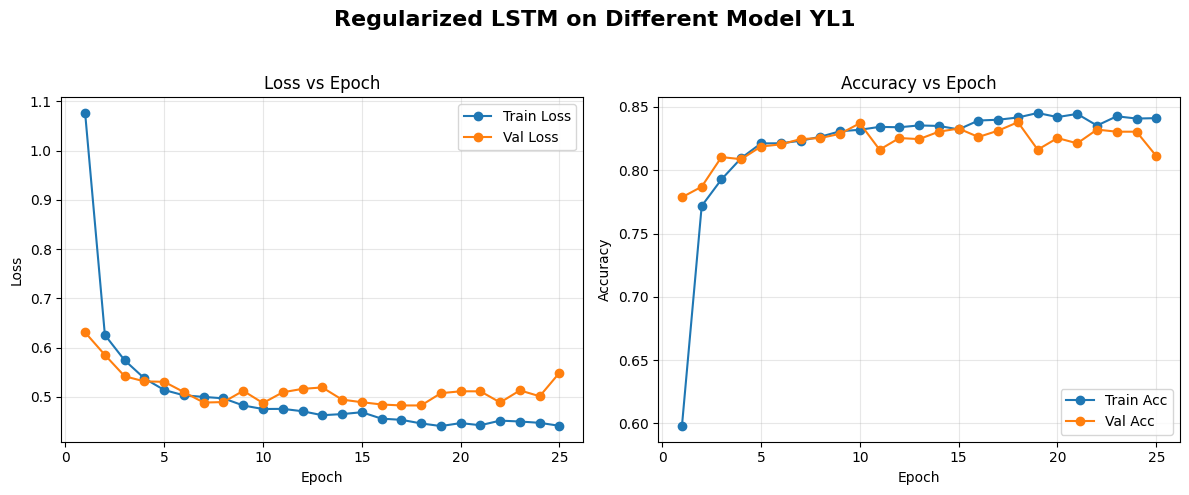

In [ ]:
plot_training_curves(model_reg1_better, title="Regularized LSTM on Different Model YL1")

In [ ]:
# Train LSTM With Weight Decay Regularization on Different Model YL2
set_seed(42)
input_dim = 300
hidden_dim = 512
num_classes = len(np.unique(yl2_train))
lstm_unit_class = LSTMUnitBase
model_reg2_better = LSTMModel(input_dim, hidden_dim, num_classes,lstm_unit_class)
model_reg2_better.fit(X_train, yl2_train, X_val=X_val, y_val=yl2_val, num_epochs=25, batch_size=64, lr=0.005, weight_decay= 1e-6)
y_test_pred = model_reg2_better.predict(X_test)
test_acc_reg2_better = LSTMModel.evaluate_acc(yl2_test, y_test_pred)
print("Test accuracy LSTM Weight Decay Regularized on YL2 Different Model:", test_acc_reg2_better)

Test accuracy LSTM Weight Decay Regularized on YL2 Different Model: 0.6115288220551378


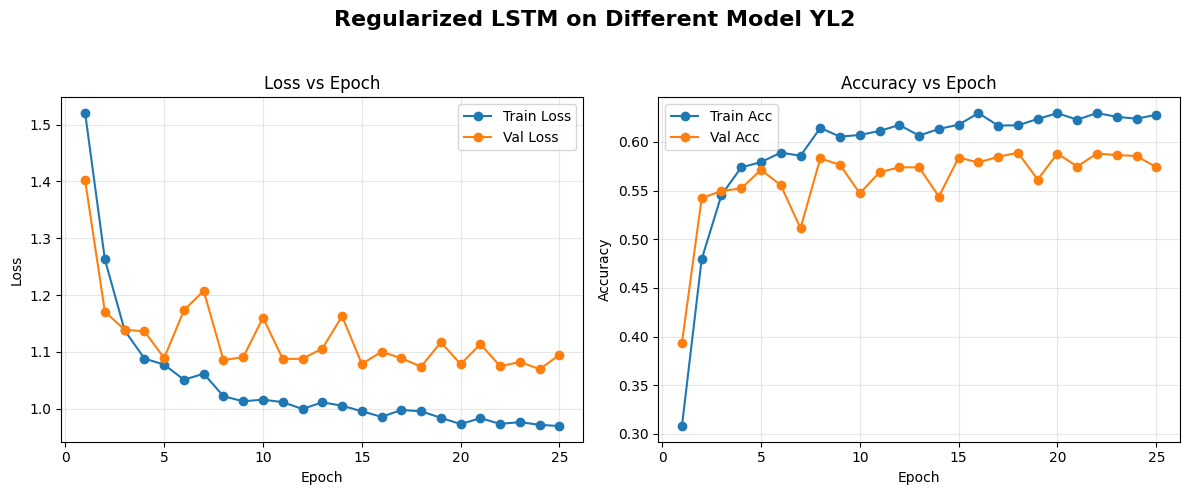

In [ ]:
plot_training_curves(model_reg2_better, title="Regularized LSTM on Different Model YL2")